# Protein Interactomes in Staphylococcus Bacteria

This project focuses on protein interactomes in two species of Staphylococcus bacteria and three subspecies of each: Staphylococcus aureus with NCTC8325, COL, and MSHR1132 subspecies and Staphylococcus epidermidis with RP62A, ATCC12228, and M23864:W1 subspecies. An interactome is a set of physical molecular interactions in an organism. In a protein interactome, every vertex represents a specific protein and edges represent whether there is physical interaction between the source and target nodes. Therefore, protein interactoms are undirected and unweighted networks. 

Unsurprisingly, the number of proteins in organisms that were developed during early stages of evolution is much less than more complex ones that were developed later in the tree of life.

In [1]:
import networkx as nx

from graspologic.utils import largest_connected_component

bac = ["S. aureus NCTC8325", "S. aureus COL", "S. aureus MSHR1132", 
        "S. epidermidis RP62A", "S. epidermidis ATCC12228", "S. epidermidis M23864W1"]

def print_num_nodes_and_edges(filename):
    g = nx.read_edgelist("./treeoflife/" + filename)
    A_lcc = largest_connected_component(g)
    print(f"Number of nodes in largest connected component in {filename}: " + str(nx.number_of_nodes(A_lcc)))
    print(f"Number of edges in largest connected component in {filename}: " + str(nx.number_of_edges(A_lcc)))
    print()
    
for i in range(6):
    print_num_nodes_and_edges(f"{bac[i]}.txt")


Number of nodes in largest connected component in S. aureus NCTC8325.txt: 491
Number of edges in largest connected component in S. aureus NCTC8325.txt: 2247

Number of nodes in largest connected component in S. aureus COL.txt: 149
Number of edges in largest connected component in S. aureus COL.txt: 275

Number of nodes in largest connected component in S. aureus MSHR1132.txt: 498
Number of edges in largest connected component in S. aureus MSHR1132.txt: 2245

Number of nodes in largest connected component in S. epidermidis RP62A.txt: 535
Number of edges in largest connected component in S. epidermidis RP62A.txt: 2395

Number of nodes in largest connected component in S. epidermidis ATCC12228.txt: 481
Number of edges in largest connected component in S. epidermidis ATCC12228.txt: 2314

Number of nodes in largest connected component in S. epidermidis M23864W1.txt: 246
Number of edges in largest connected component in S. epidermidis M23864W1.txt: 445



# Plotting Networks
All six networks contain some isolated vertices and, therefore, largest connected component is used for smooth analysis and visualization. These networks are also significantly sparse since the actual number of edges is much lower than possible number of edges (number of vertices to the power of 2).
## Heatmaps of Adjacency Matrices
Since networks are sparse, we expect many zeros in the adjacency matrix which is translated into white space on the heatmaps. 

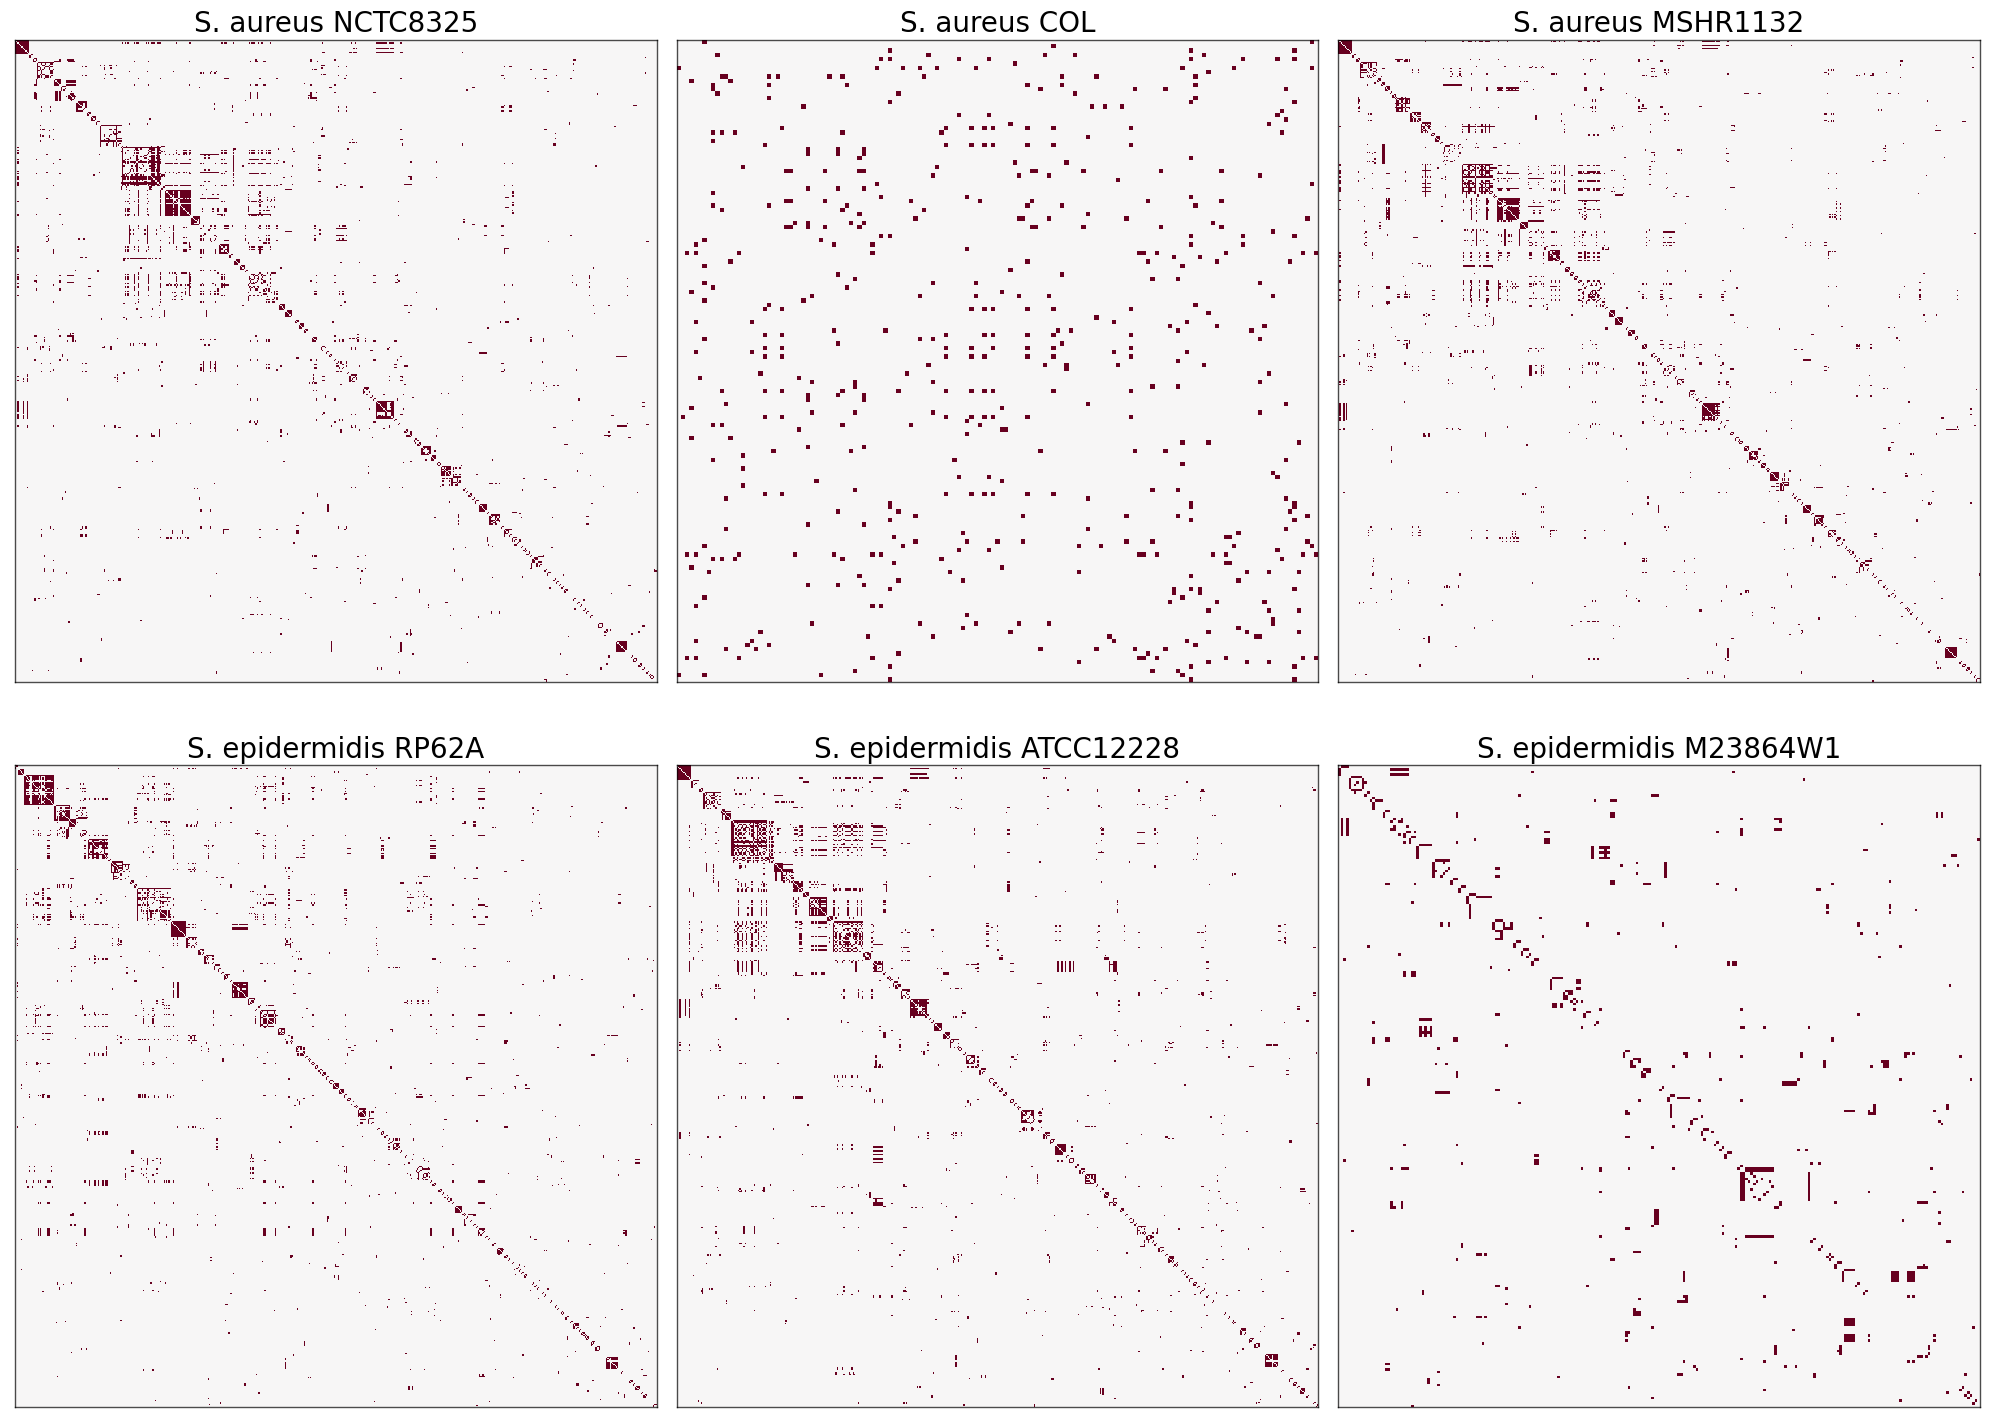

In [2]:
import matplotlib.pyplot as plt

from graspologic.plot import adjplot

def plot_heatmap(title, ax):
    G = nx.read_edgelist("./treeoflife/" + f"{title}.txt")
    A_lcc = largest_connected_component(G)
    A_lcc = nx.to_numpy_array(A_lcc)
    ax.set_title(title, size=20)
    adjplot(A_lcc, plot_type="heatmap", ax=ax)
    
fig, axs = plt.subplots(2, 3, figsize=(20, 15))

k = 0
for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        plot_heatmap(f"{bac[k]}", ax)
        k += 1

plt.tight_layout()

###### The heatmaps for S. aureus NCTC8325, S. aureus MSHR1132, S. epidermidis RP62A, and S. epidermidis ATCC12228 have significant similarities in pattern that could turn into interesting results!

## Network Layouts
Since the number of proteins (vertices) in these bactera is not relatively large and their interactomes are sparse, Kamada Kawai layout is a good candidate for network layout visualization.

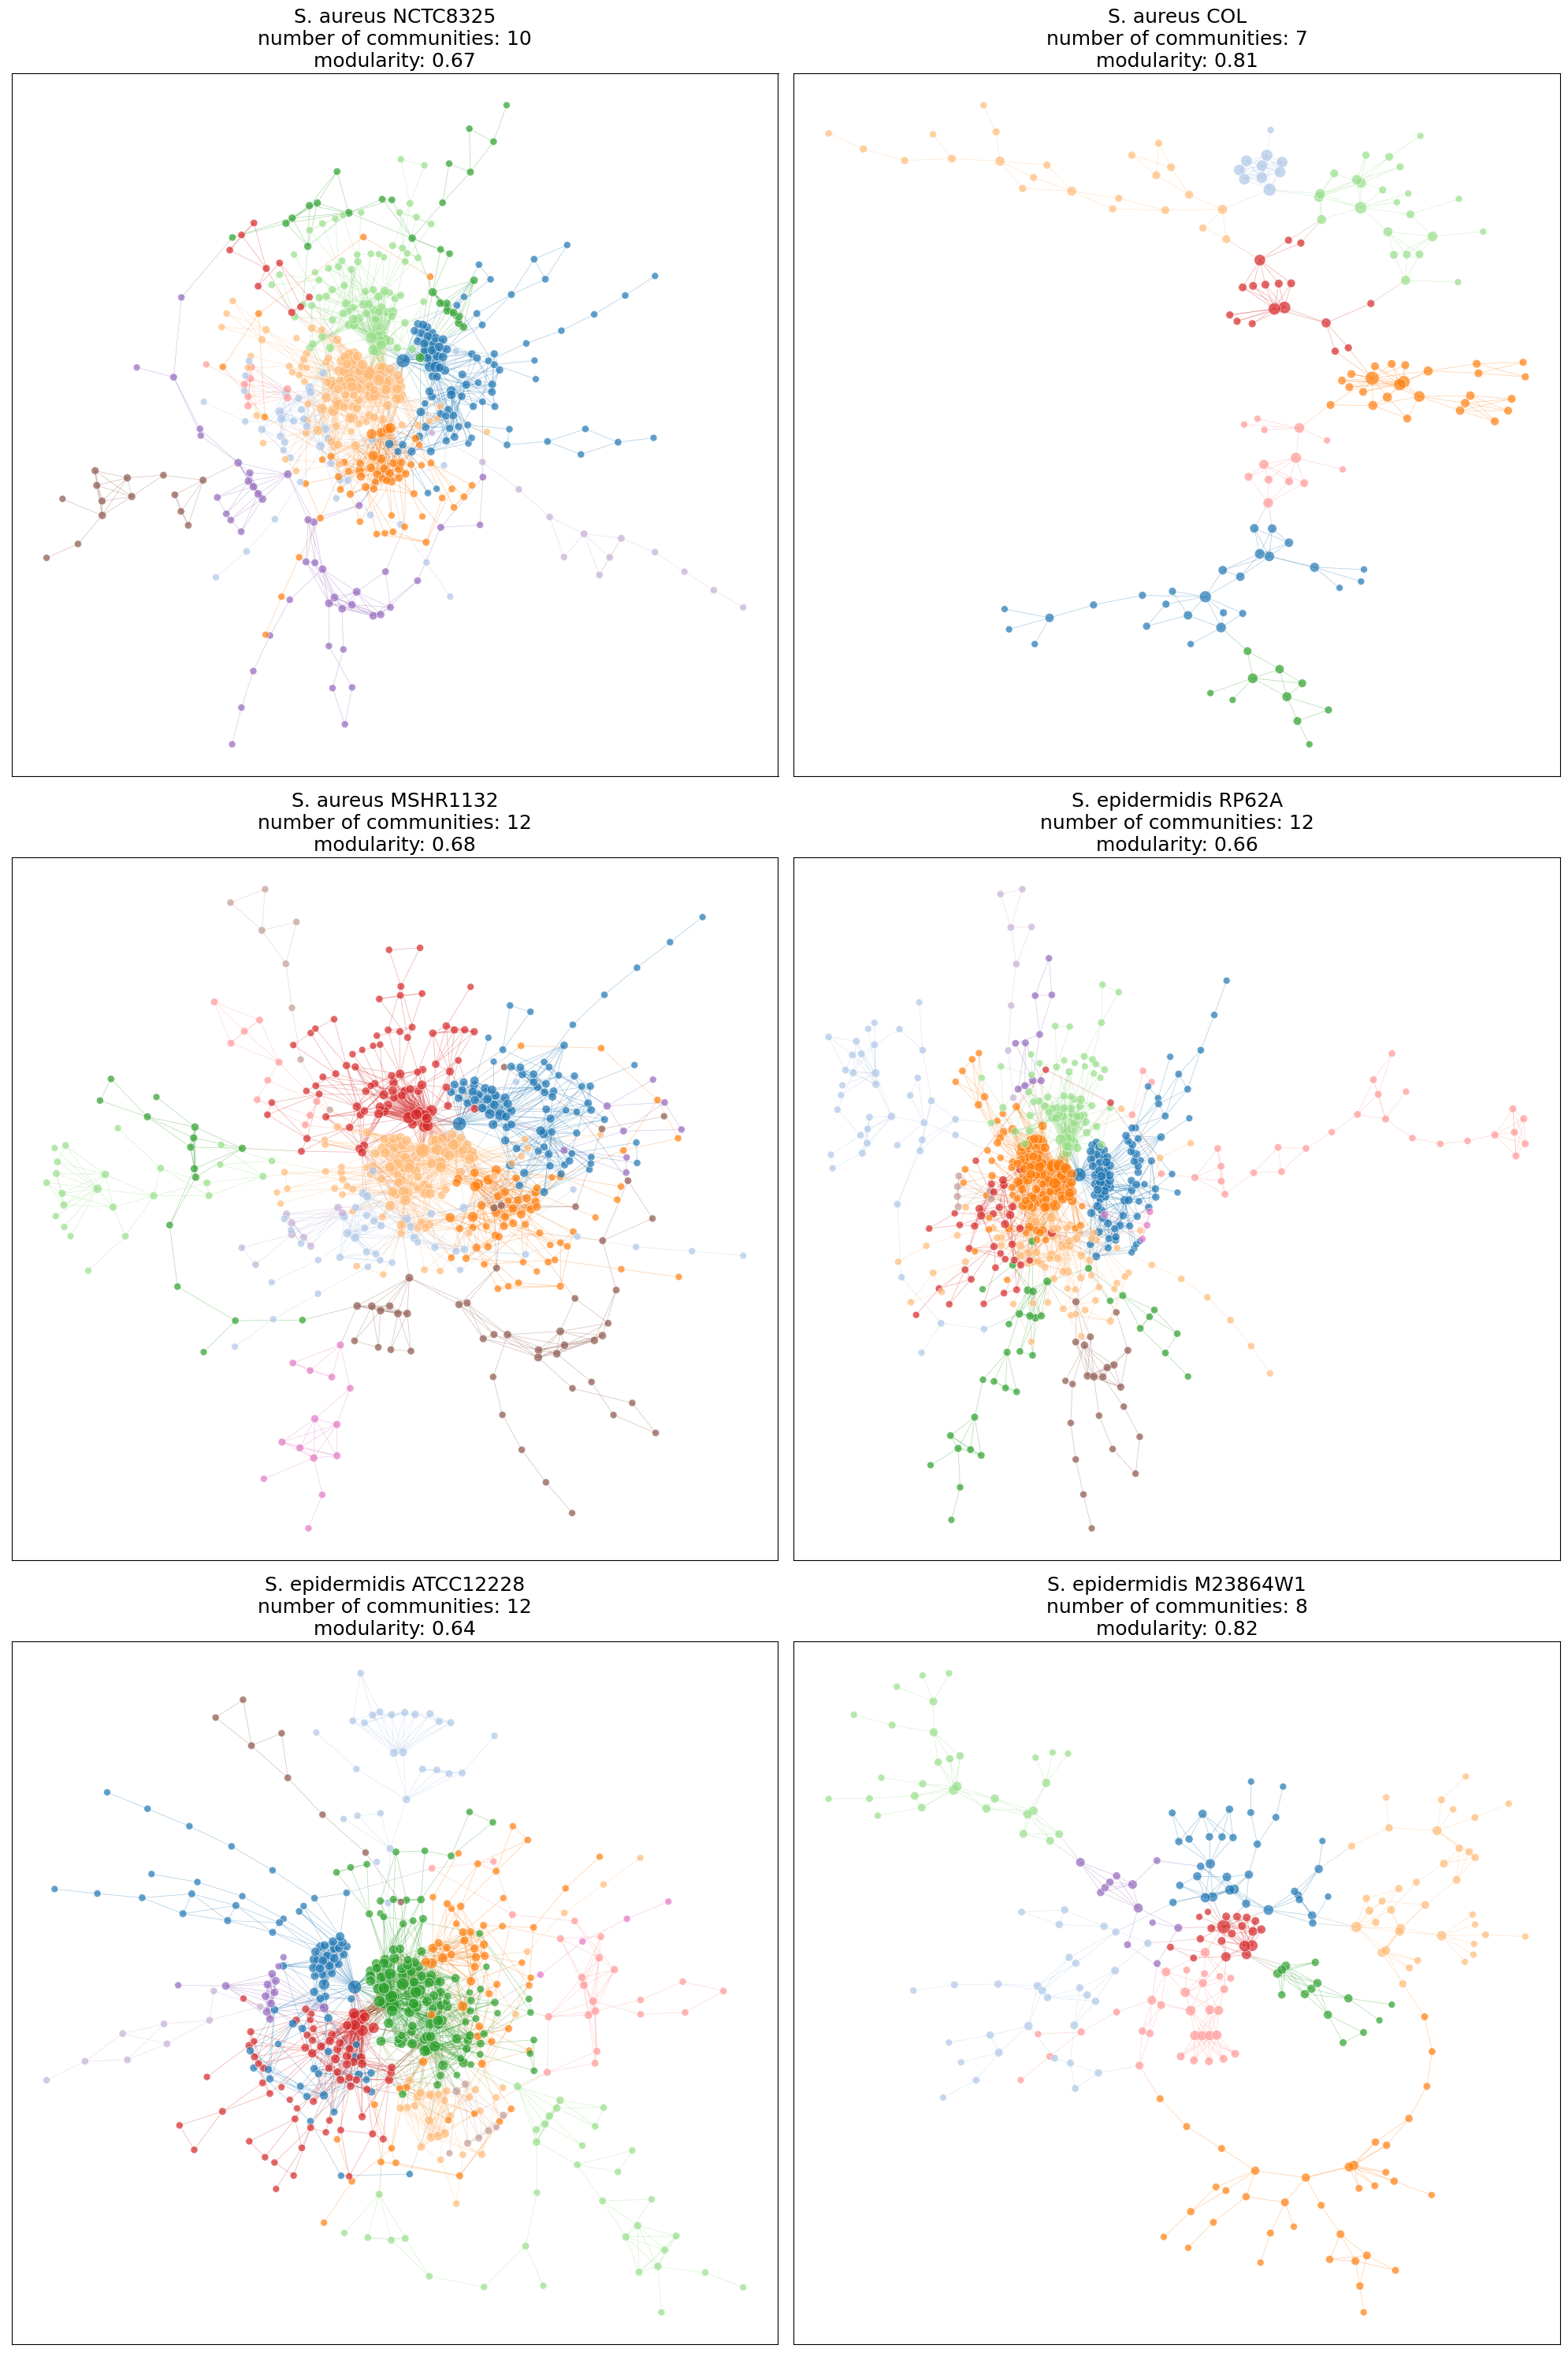

In [3]:
from graspologic.partition import leiden, modularity
from graspologic.plot import networkplot

import pandas as pd
import numpy as np

def plot_partition(title, ax):
    G = nx.read_edgelist("./treeoflife/" + f"{title}.txt")
    A_lcc = largest_connected_component(G)
    G = A_lcc
    nodelist = list(G.nodes)
    
    nx.set_edge_attributes(G, 1, "weight")
    node_df = pd.DataFrame(index=nodelist)
    pos = nx.kamada_kawai_layout(G, dim=2)
    
    xs = []
    ys = []
    for node in list(G.nodes):
        xs.append(pos[node][0])
        ys.append(pos[node][1])
    xs = np.array(xs)
    ys = np.array(ys)
    
    node_df["x"] = xs
    node_df["y"] = ys
        
    leiden_partition_map = leiden(A_lcc, trials=100, resolution=0.5)
    node_df["leiden"] = node_df.index.map(leiden_partition_map)
    
    A_lcc = nx.to_numpy_array(A_lcc, nodelist=nodelist)
    node_df["degree"] = A_lcc.sum(axis=0)
    
    communities = set(leiden_partition_map.values())
    mod = modularity(G, leiden_partition_map)
    mod = "%.2f" % mod
    
    networkplot(
        A_lcc,
        x="x",
        y="y",
        node_data=node_df.reset_index(),
        node_size="degree",
        node_alpha=0.7,
        edge_linewidth=0.5,
        node_hue="leiden",
        ax=ax,
        title=title+f"\nnumber of communities: {max(communities)}\nmodularity: {mod}",
        palette="tab20"
    )

fig, axs = plt.subplots(3, 2, figsize=(20, 30))

k = 0
for i in range(3):
    for j in range(2):
        ax = axs[i][j]
        plot_partition(f"{bac[k]}", ax)
        k += 1

plt.tight_layout()
    

###### Even the network layouts for S. aureus NCTC8325, S. aureus MSHR1132, S. epidermidis RP62A, and S. epidermidis ATCC12228 are significantly similar. There are certain vertices (the large red vertex in the center) that are shared as more connected vertices across all four interactomes. In addition, the number and spread of communities in these subspecies is roughly the same with Leiden resolution of 0.50. This further supports the similarity of interactomes in these 4 subspecies.

# Random Network Model: SBM
I chose stochastic block model (SBM) to prove the strength of communities in my each interactome.

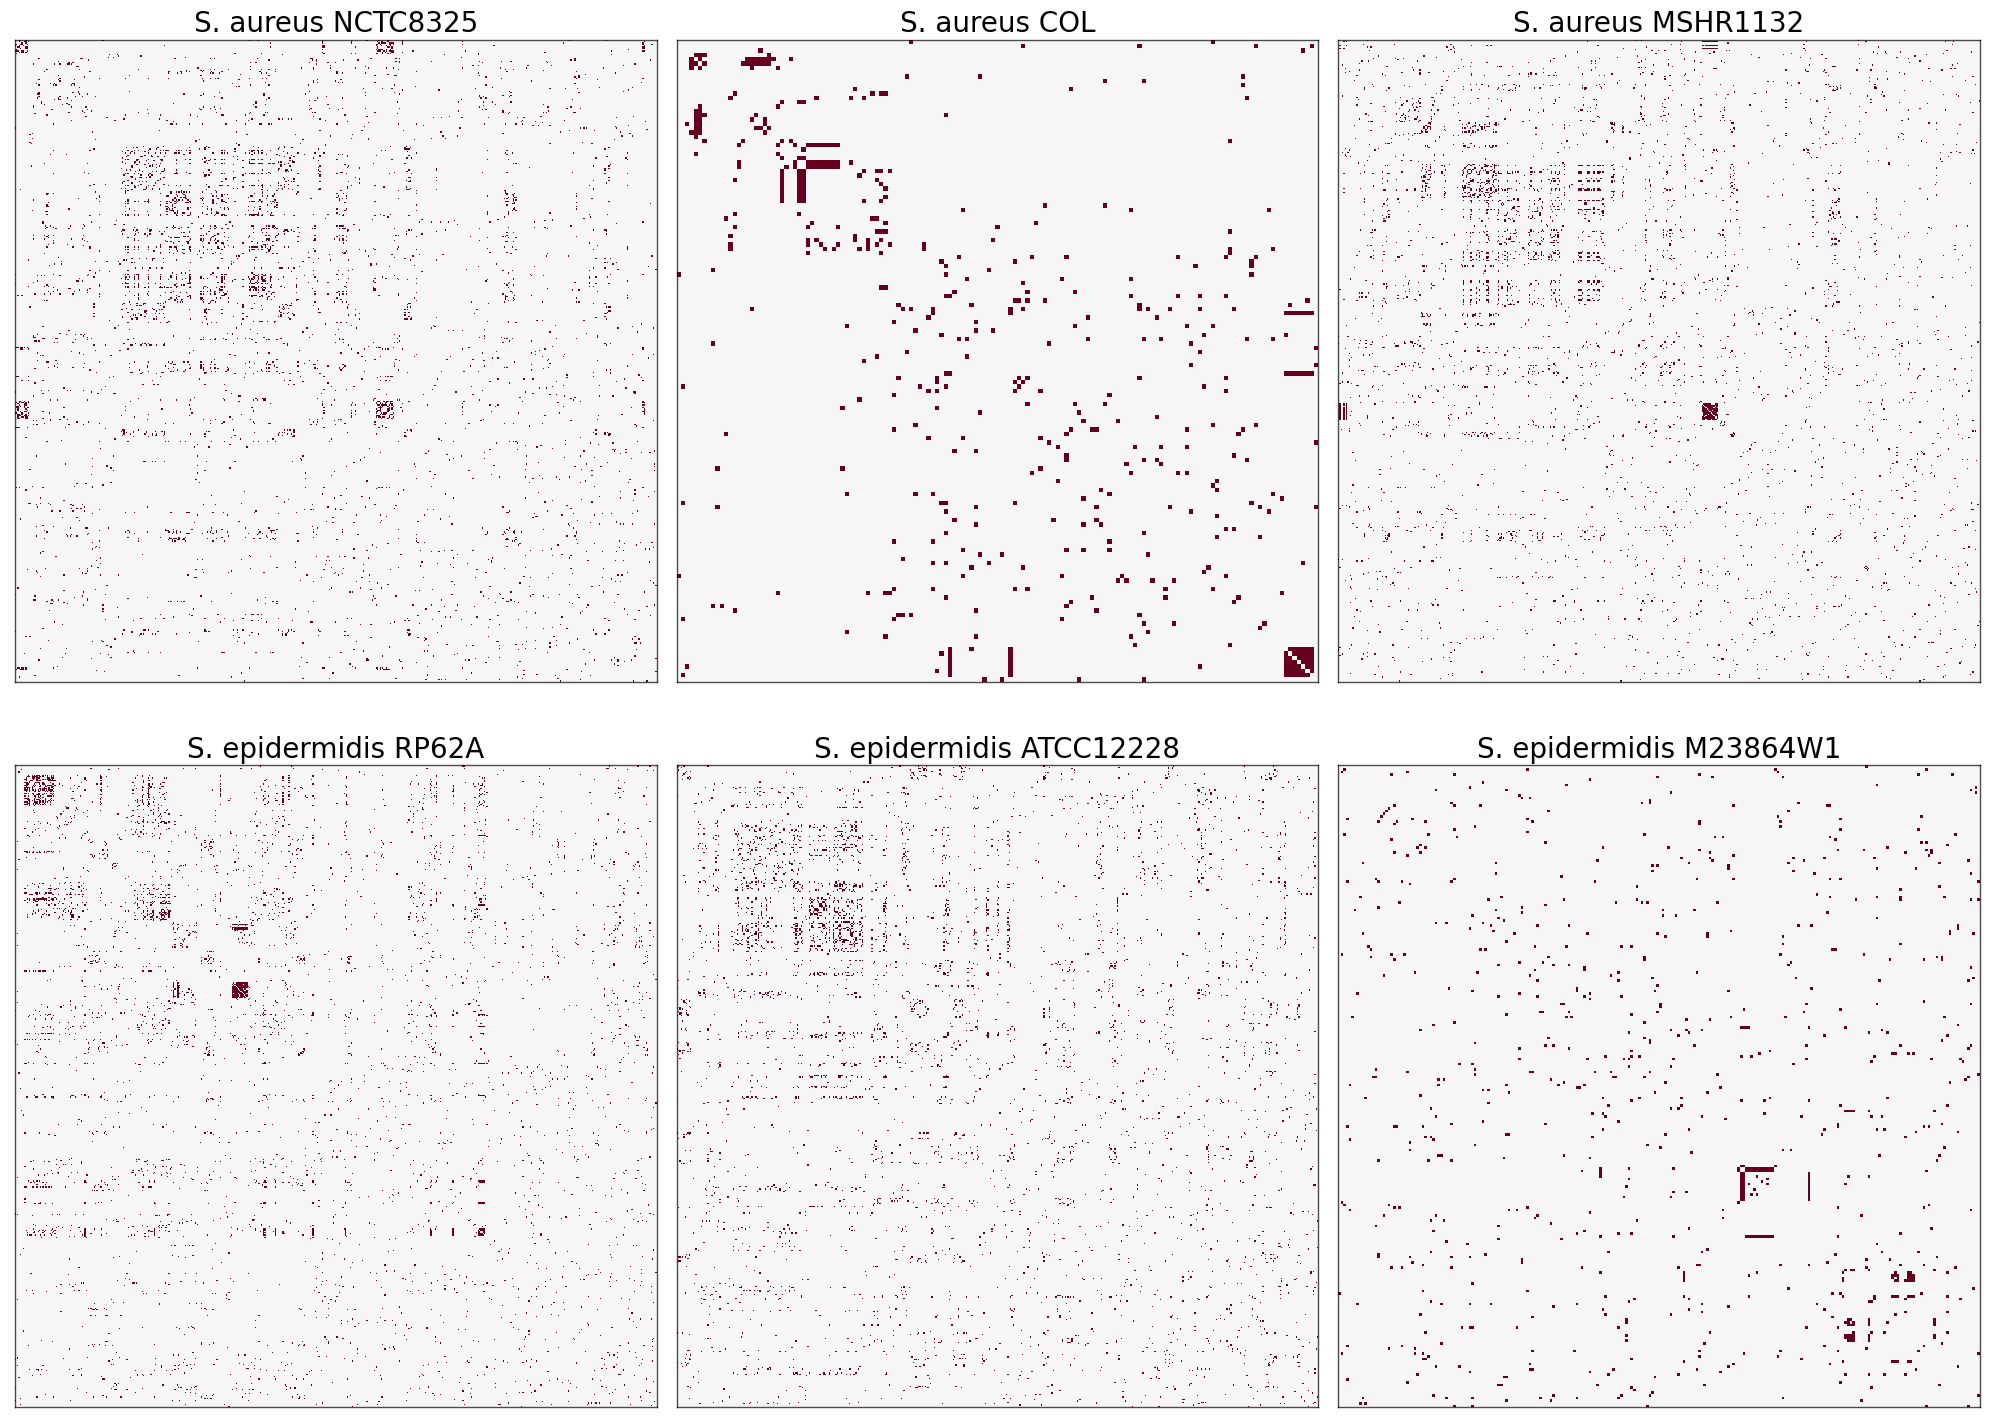

In [4]:
from graspologic.models import SBMEstimator

def plot_estimator(title, ax, plot_type="heatmap", sizes=(10, 10)):
    G = nx.read_edgelist("./treeoflife/" + f"{title}.txt")
    A = nx.to_numpy_array(G)
    A_lcc = largest_connected_component(A)

    sbme = SBMEstimator(directed=False, loops=False)
    sbme.fit(A_lcc)
    ax.set_title(title, size=20)
    adjplot(sbme.sample()[0], plot_type=plot_type, ax=ax, sizes=sizes)
    
fig, axs = plt.subplots(2, 3, figsize=(20, 15))

k = 0
for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        plot_estimator(f"{bac[k]}", ax)
        k += 1

plt.tight_layout()

##### It seems that my dataset is not large enough for such an estimator to be an ideal model.  I also tried random dot product graph (RDPG) model and the result was roughly the same. It seems that these models generally work better for networks with more vertices. For example, for Homo sapiens interactome which has over 16000 vertices and more than 9000 are in a single community, the result looks like:

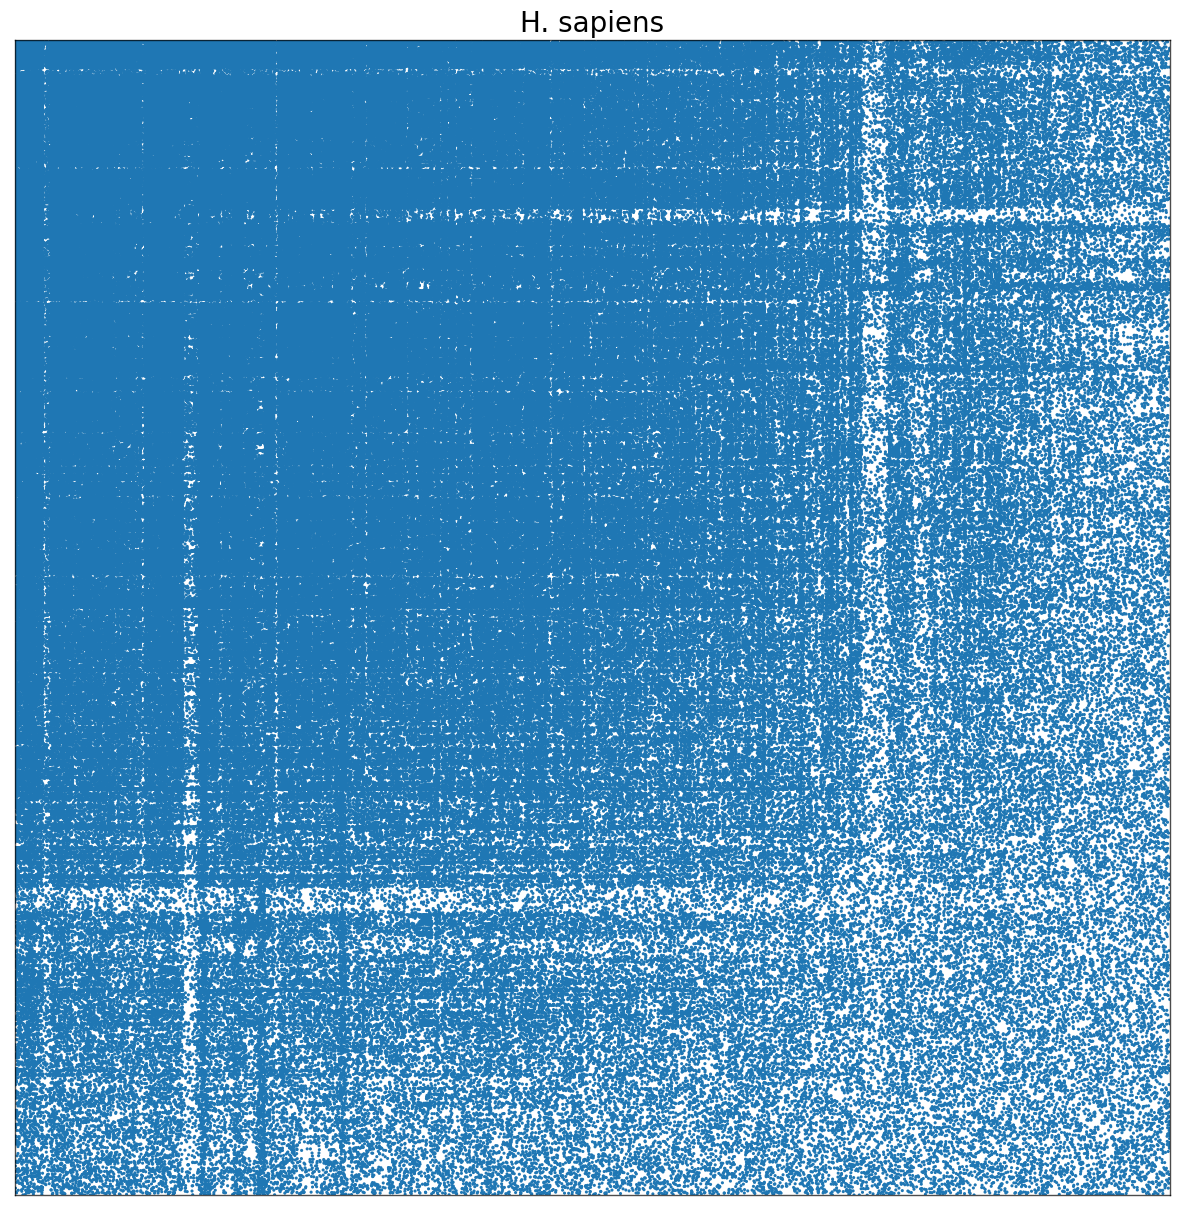

In [5]:
from IPython import display
display.Image("human.png")

# Graph Matching
So far, we have noticed that the number of proteins in the largest connected component of S. aureus NCTC8325, S. aureus MSHR1132, S. epidermidis RP62A, and S. epidermidis ATCC12228 are very close to each other, their adjacency matrix heatmaps follow the similar patterns, and their layouts indicate similar proteins as most important (connected) vertices. As a result, graph matching is appropriate to test the hypothesis of important proteins that are shared between these 4 subspecies.

First, I created a new list of these 4 subspecies and added them as a node to a graph to later plot their edge difference ratioes to each other.

In [6]:
imp_bac = ["S. aureus NCTC8325", "S. aureus MSHR1132", 
           "S. epidermidis RP62A", "S. epidermidis ATCC12228"]

H = nx.Graph()

for val in imp_bac:
    H.add_node(val)

I decided to plot all possible combination of the differences between the four subspecies. I used graspologic graph_match to find the predicted permutation for the second graph at every iteration. I plotted the permutation of the first and second graphs returned by graph_match() as well as the plot of their edge differences.

In [7]:
from graspologic.match import graph_match

def output_diff_plots(title1, title2, ax):
    G1 = nx.read_edgelist("./treeoflife/" + f"{title1}.txt")  
    A1 = nx.to_numpy_array(G1, nodelist=list(G1.nodes))
    A1 = largest_connected_component(A1)
    
    G2 = nx.read_edgelist("./treeoflife/" + f"{title2}.txt")
    A2 = nx.to_numpy_array(G2, nodelist=list(G2.nodes))
    A2 = largest_connected_component(A2)

    perm_A1, perm_A2, score, misc = graph_match(A1, A2, n_init=3, n_jobs=-1)
    A1 = A1[perm_A1][:, perm_A1]
    A2 = A2[perm_A2][:, perm_A2]
    diff = np.sum(abs(A2 - A1)) / (np.sum(A1) + np.sum(A2))
    H.add_edge(title1, title2, weight=diff)
    diff = "%.2f" % diff
    ax[0].set_title(f"{title1}", size=20)
    ax[1].set_title(f"{title2}", size=20)
    ax[2].set_title(f"{title1} and {title2}\n edge difference ratio: {diff}", size=20)
    adjplot(A1, plot_type="heatmap", ax=ax[0])
    adjplot(A2, plot_type="heatmap", ax=ax[1])
    adjplot(A2 - A1, plot_type="heatmap", ax=ax[2])
        
fig, axs = plt.subplots(6, 3, figsize=(25, 45))
        
axsi = 0
for i in range(4):
    for j in range(4):
        if (i >= j):
            continue
        output_diff_plots(imp_bac[i], imp_bac[j], axs[axsi])
        axsi += 1

plt.tight_layout()

Here is a heatmap of how every two subspecies are similar in terms of protein interactomes.

<AxesSubplot: >

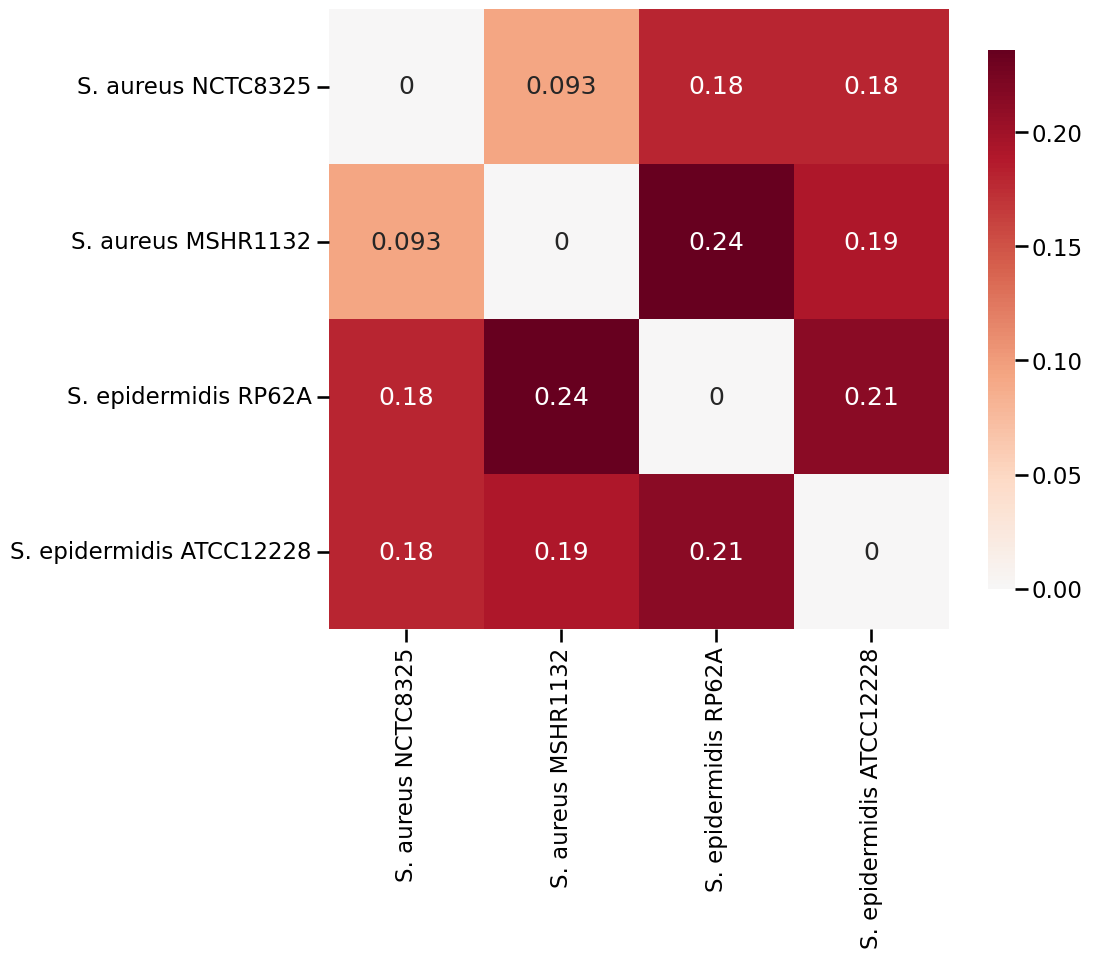

In [8]:
from graspologic.plot import heatmap

H_arr = nx.to_numpy_array(H)
heatmap(H_arr, annot=True, xticklabels=imp_bac, yticklabels=imp_bac)

# Results
## Most Connected Proteins
### How much of a single cell function is dependent on one protein?
Let's find top 3 most connected proteins in each network.

In [9]:
top_nodes = []
def top_ten_nodes(title):
    G = nx.read_edgelist("./treeoflife/" + f"{title}.txt")  
    neighbors = {}
    for node in list(G.nodes):
        neighbors[node] = len(list(G.neighbors(n=node)))
    keys = list(neighbors.keys())
    values = list(neighbors.values())
    sorted_value_index = np.argsort(values)[::-1]
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    
    local_top_nodes = []
    for i in range(3):
        local_top_nodes.append(keys[i])
    top_nodes.append(local_top_nodes)

for i in range(6):
    top_ten_nodes(bac[i])

top_nodes

[['SAOUHSC_00002', 'SAOUHSC_01690', 'SAOUHSC_01806'],
 ['SACOL0005', 'SACOL0006', 'SACOL0008'],
 ['SAMSHR1132_00020', 'SAMSHR1132_15480', 'SAMSHR1132_04220'],
 ['SERP0001', 'SERP1823', 'SERP0002'],
 ['SE0002', 'SE2299', 'SE1156'],
 ['HMPREF0793_0006', 'HMPREF0793_0046', 'HMPREF0793_1188']]

#### S. aureus NCTC8325 
SAOUHSC_00002, SAOUHSC_01690: DNA Polymerase III subunits, responsible for DNA replication, recombination, and repair

SAOUHSC_01806: pyruvate kinase, responsible for conversion of ADP to ATP and cell metabolism

#### S. aureus COL
SACOL0005, SACOL0006: DNA gyrase subunit, catalyzes the ATP-dependent negative super-coiling (twisting) of DNA 

SACOL0008: histidine ammonia-lyase, degrades histidine to ammonia 

#### S. aureus MSHR1132

SAMSHR1132_00020, SAMSHR1132_04220: DNA Polymerase III subunits, responsible for DNA replication, recombination, and repair

SAMSHR1132_15480: pyruvate kinase, responsible for conversion of ADP to ATP and cell metabolism

#### S. epidermidis RP62A

SERP0001, SERP1823: ribosomal protein, required for translation

SERP0002: ribonuclease protein component, the component is responsible for degrading RNA 

#### S. epidermidis ATCC12228

SE0002: ribonuclease protein component, the component is responsible for degrading RNA

SE2299: DNA Polymerase III subunits, responsible for DNA replication, recombination, and repair

SE1156: nucleoside diphosphate kinase, catalyzes production of nucleoside triphosphate (like ATP)

#### S. epidermidis M23864:W1

Could not find!

Firstly, the same proteins are the most connected in both S. aureus NCTC8325 and S. aureus MSHR1132. This justifies the lowest observed edge ratio between all species. 

Secondly, the most connected proteins are the proteins that correspond with the survival of a single cell, as expected. The above list shows that in the genus of Staphylococcus bacteria, proteins responsible for transcription and translation as well as those involved in mechanisms that provide energy for the cell are dominantly connected to other proteins.

## Most Similar Subspecies
### What are the most most similar subspecies among 4 subspecies of Staphycoccolus bacteria?
From my results, it is clear that S. aureus NCTC8325 and S. aureus MSHR1132 are the most similar subspecies as their edge difference ratio is as low as 7.1% and they share the most connected proteins.

On the other hand, it seems that S. epidermidis ATCC12228 and epidermidis RP62A do not have that level of similarity. In fact, S. epidermidis ATCC12228 usually (since graph matching is indeterminate) matches more closely with the S. aureus NCTC8325 and S. aureus MSHR1132 subspecies.
### Can two bacteria from different species be more similar than two subspecies?

Based on my results, I tend to believe so...

DNA Polymerase III subunits are most connected in S. aureus NCTC8325, S. aureus MSHR1132, and S. epidermidis ATCC12228 but not in epidermidis RP62A. This could partially justify the fact that the ATCC12228 subspecies is in fact more similar to the aureus subspecies than it is to other epidermidis subspecies.

In addition to DNA Polymerase III, kinase enzymes are also shared common as top nodes among S. aureus NCTC8325, S. aureus MSHR1132, and S. epidermidis ATCC12228 but not in epidermidis RP62A. 

Note that the number of nodes in the RP62A is also relatively larger than the other three subspecies which could justify why the edge difference ratio may be higher in some graph matching trials.